In [1]:
import torch
import os
from torch import nn, cuda, backends, manual_seed, tensor
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.autograd import Variable
from model.model import EncoderRNN, DecoderRNN
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
from pathlib import Path
from tqdm import tqdm
import data.dataset as dataset_lib
from model.constants import MIN_LENGTH, MAX_LENGTH
import ar_vae_metrics as m
from scipy import stats
import torch
import os
from torch import optim, nn, logsumexp, cuda, save, backends, manual_seed, LongTensor, zeros_like, ones_like, tensor, cat
from torch.distributions import Normal
from torch.utils.data import TensorDataset, DataLoader, random_split
torch.autograd.set_detect_anomaly(True)
from model.model import EncoderRNN, DecoderRNN
import numpy as np
import clearml
from typing import Optional, Literal
from torch.optim import Adam
import itertools
import random
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import data.dataset as dataset_lib
from model.constants import MIN_LENGTH, MAX_LENGTH, VOCAB_SIZE
import ar_vae_metrics as m
import monitoring as mn
import regularization as r
from sklearn.decomposition import IncrementalPCA
import pandas as pd

In [2]:
def set_seed(seed: int = 42) -> None:
    """
    Source:
    https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy
    """
    np.random.seed(seed)
    random.seed(seed)
    manual_seed(seed)
    cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    backends.cudnn.deterministic = True
    backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    # logger.info(f"Random seed set to {seed}")
    return None

In [3]:
def convert_rgba_to_rgb(rgba):
    row, col, ch = rgba.shape
    if rgba.dtype == 'uint8':
        rgba = rgba.astype('float32') / 255.0
    if ch == 3:
        return rgba
    assert ch == 4
    rgb = np.zeros((row, col, 3), dtype='float32')
    r, g, b, a = rgba[:, :, 0], rgba[:, :, 1], rgba[:, :, 2], rgba[:, :, 3]
    a = np.asarray(a, dtype='float32')

    rgb[:, :, 0] = r * a + (1.0 - a)
    rgb[:, :, 1] = g * a + (1.0 - a)
    rgb[:, :, 2] = b * a + (1.0 - a)

    return np.asarray(rgb)

In [73]:
def plot_dim(data1, target1, data2, target2, filename, dim2=1, xlim=None, ylim=None):
    attr = ['Length', 'Charge' , 'Hydrophobic moment']
    n_rows = 3
    n_cols = 2
    n_plots = n_rows * n_cols
    
    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(13, 15),
        dpi=150           
    )
    axes_flat = axes.flatten()
    min_1row = np.min(np.concatenate((target1[0,:,0], target2[0,:,0])))
    max_1row = np.max(np.concatenate((target1[0,:,0], target2[0,:,0])))
    min_2row = np.min(np.concatenate((target1[1,:,1], target2[1,:,1])))
    max_2row = np.max(np.concatenate((target1[1,:,1], target2[1,:,1])))
    min_3row = np.min(np.concatenate((target1[2,:,2], target2[2,:,2])))
    max_3row = np.max(np.concatenate((target1[2,:,2], target2[2,:,2])))
    axes[0,0].scatter(
                x=data1[0,:, 0],
                y=data1[0,:, dim2],
                c=target1[0,:,0],
                s=12,
                linewidths=0,
                cmap="viridis",
                alpha=0.5,
                vmin=min_1row,   # Ustawiamy globalne min/max dla kolorów
                vmax=max_1row   # Ustawiamy globalne min/max dla kolorów
    )
    axes[0,0].set_title(f'VAE', fontsize = 16)
    axes[0,0].set_xlabel(f'dimension: {attr[0]}', fontsize=14)
    axes[0,0].set_ylabel(f'not regularized dimension', fontsize=14)
    axes[0,1].scatter(
                x=data2[0,:, 0],
                y=data2[0,:, dim2],
                c=target2[0,:,0],
                s=12,
                linewidths=0,
                cmap="viridis",
                alpha=0.5,
                vmin=min_1row,   # Ustawiamy globalne min/max dla kolorów
                vmax=max_1row   # Ustawiamy globalne min/max dla kolorów
    )
    axes[0,1].set_title(f'AR-VAE', fontsize = 16)
    axes[0,1].set_xlabel(f'dimension: {attr[0]}', fontsize=14)
    axes[1,0].scatter(
                x=data1[1,:, 1],
                y=data1[1,:, dim2],
                c=target1[1,:,1],
                s=12,
                linewidths=0,
                cmap="viridis",
                alpha=0.5,
                vmin=min_2row,   # Ustawiamy globalne min/max dla kolorów
                vmax=max_2row   # Ustawiamy globalne min/max dla kolorów
    )
    # axes[1,0].set_title(f'{attr[1]} for IWAE')
    axes[1,0].set_xlabel(f'dimension: {attr[1]}', fontsize=14)
    axes[1,0].set_ylabel(f'not regularized dimension', fontsize=14)
    axes[1,1].scatter(
                x=data2[1,:, 1],
                y=data2[1,:, dim2],
                c=target2[1,:,1],
                s=12,
                linewidths=0,
                cmap="viridis",
                alpha=0.5,
                vmin=min_2row,   # Ustawiamy globalne min/max dla kolorów
                vmax=max_2row   # Ustawiamy globalne min/max dla kolorów
    )
    # axes[1,1].set_title(f'{attr[1]} for AR-VAE')
    axes[1,1].set_xlabel(f'dimension: {attr[1]}', fontsize=14)
    axes[2,0].scatter(
                x=data1[2,:, 2],
                y=data1[2,:, dim2],
                c=target1[2,:,2],
                s=12,
                linewidths=0,
                cmap="viridis",
                alpha=0.5,
                vmin=min_3row,   # Ustawiamy globalne min/max dla kolorów
                vmax=max_3row   # Ustawiamy globalne min/max dla kolorów
    )
    # axes[2,0].set_title(f'{attr[2]} for IWAE')
    axes[2,0].set_xlabel(f'dimension: {attr[2]}', fontsize=14)
    axes[2,0].set_ylabel(f'not regularized dimension', fontsize=14)
    axes[2,1].scatter(
                x=data2[2,:, 2],
                y=data2[2,:, dim2],
                c=target2[2,:,2],
                s=12,
                linewidths=0,
                cmap="viridis",
                alpha=0.5,
                vmin=min_3row,   # Ustawiamy globalne min/max dla kolorów
                vmax=max_3row   # Ustawiamy globalne min/max dla kolorów
    )
    # axes[2,1].set_title(f'{attr[2]} for AR-VAE')
    axes[2,1].set_xlabel(f'dimension: {attr[2]}', fontsize=14)
    # for i, ax in enumerate(axes_flat):
    #     ax.set_ylabel(f'not regularized dimension', fontsize=14)
    cbar_ax_0_row = fig.colorbar(
        # Użyj obiektu mappable z DOWOLNEGO wykresu w tym rzędzie,
        # ponieważ wszystkie używają tego samego cmap, vmin i vmax
        axes[0, 0].collections[0], # collections[0] to zazwyczaj obiekt Scatter
        ax=axes[0, :].ravel().tolist(), # Kluczowe: Lista osi dla pierwszego rzędu
        label='Length',
        shrink=0.8, # Zmniejsz pasek kolorów, aby lepiej pasował
        aspect=20 # Kontroluje proporcje paska kolorów
    )
    cbar_ax_0_row.ax.set_ylabel('')
    # Przykład dla drugiego rzędu (wykresy w kolumnach 0 i 1 w rzędzie 1)
    cbar_ax_1_row = fig.colorbar(
        axes[1, 0].collections[0],
        ax=axes[1, :].ravel().tolist(), # Kluczowe: Lista osi dla drugiego rzędu
        label='Charge',
        shrink=0.8,
        aspect=20
    )
    cbar_ax_1_row.ax.set_ylabel('')
    # Możesz powtórzyć to dla pozostałych rzędów (axes[2, :] i axes[3, :])
    cbar_ax_2_row = fig.colorbar(
        axes[2, 0].collections[0],
        ax=axes[2, :].ravel().tolist(), # Kluczowe: Lista osi dla trzeciego rzędu
        label='Hydrophobic moment',
        shrink=0.8,
        aspect=20
    )
    cbar_ax_2_row.ax.set_ylabel('')
    plt.savefig(filename, format='png', dpi=150)

In [74]:
def plot_latent_surface(q_distr,decoder_iwae, decoder_arvae, dim1=[0], dim2=1, grid_res=0.05, z_dim = 56):
    attr = ['Length', 'Charge' , 'Hydrophobic moment']
    all_final_z_points_iwae = []
    all_final_attr_labels_iwae = []
    all_final_z_points_arvae = []
    all_final_attr_labels_arvae = []
    for d in dim1:
        dim_z_iwae = []
        dim_attr_iwae = []
        dim_z_arvae = []
        dim_attr_arvae = []
        attr_labels_all = []


        for batch, labels, physchem, attributes_input in train_loader: 
            peptides = batch.permute(1, 0).type(LongTensor).to(DEVICE) # S x B

            mu, std = encoder_iwae(peptides)
            z_iwae = mu.clone()
            outputs_iwae = decoder_iwae(z_iwae)
            src_iwae = outputs_iwae.permute(1, 2, 0)  # B x C x S
            src_decoded_iwae = src_iwae.argmax(dim=1) # B x S
            decoded_iwae = dataset_lib.decoded(src_decoded_iwae, "") 
            labels_iwae = dataset_lib.calculate_physchem_test(decoded_iwae)

    
            mu, std = encoder_arvae(peptides)
            z_arvae = mu.clone()
            outputs_arvae = decoder_arvae(z_arvae)
            src_arvae = outputs_arvae.permute(1, 2, 0)  # B x C x S
            src_decoded_arvae = src_arvae.argmax(dim=1) # B x S
            decoded_arvae = dataset_lib.decoded(src_decoded_arvae, "") 
            labels_arvae = dataset_lib.calculate_physchem_test(decoded_arvae)
    
                        
            dim_z_iwae.append(z_iwae.detach().cpu().numpy())
            dim_attr_iwae.append(labels_iwae.detach().cpu().numpy())
            dim_z_arvae.append(z_arvae.detach().cpu().numpy())
            dim_attr_arvae.append(labels_arvae.detach().cpu().numpy())

        dim_z_iwae = np.vstack(dim_z_iwae)
        dim_attr_iwae = np.vstack(dim_attr_iwae)
        dim_z_arvae = np.vstack(dim_z_arvae)
        dim_attr_arvae = np.vstack(dim_attr_arvae)
        
        all_final_z_points_iwae.append(dim_z_iwae)
        all_final_attr_labels_iwae.append(dim_attr_iwae)
        all_final_z_points_arvae.append(dim_z_arvae)
        all_final_attr_labels_arvae.append(dim_attr_arvae)
        
    aggregated_z_points_iwae = np.stack(all_final_z_points_iwae)
    aggregated_attr_labels_iwae = np.stack(all_final_attr_labels_iwae)
    aggregated_z_points_arvae = np.stack(all_final_z_points_arvae)
    aggregated_final_attr_labels_arvae = np.stack(all_final_attr_labels_arvae)
    save_filename = os.path.join(
            os.getcwd(),
            f'latent_surface_{dim2}dim.png'
    )
    # print(f'aggregated_z_points_iwae = {aggregated_z_points_iwae.shape}')
    plot_dim(aggregated_z_points_iwae, aggregated_attr_labels_iwae, aggregated_z_points_arvae, aggregated_final_attr_labels_arvae, save_filename, dim2=dim2)

In [6]:
set_seed()

In [7]:
    global ROOT_DIR 
    ROOT_DIR = Path().resolve()
    DATA_DIR = ROOT_DIR / "data"
    global MODELS_DIR 
    MODELS_DIR = ROOT_DIR
    params = {
        "num_heads": 4,
        "num_layers": 6,
        "layer_norm": True,
        "latent_dim": 56,
        "encoding": "add",
        "dropout": 0.1,
        "batch_size": 512,
        "lr": 0.001,
        "train_size": None,
        "iwae_samples": 10,
        "model_name": os.getenv("CLEARML_PROJECT_NAME", 'ar-vae-v4'),
        "use_clearml": True,
        "task_name": os.getenv("CLEARML_TASK_NAME", "ar-vae 3 dims"),
        "device": "cuda",
        "deeper_eval_every": 20,
        "save_model_every": 20,
        "ar_vae_flg": False,
        "reg_dim": [0,1,2], # [length, charge, hydrophobicity_moment]
    }
    encoder_iwae = EncoderRNN(
        params["num_heads"],
        params["num_layers"],
        params["latent_dim"],
        params["encoding"],
        params["dropout"],
        params["layer_norm"],
    )
    decoder_iwae = DecoderRNN(
        params["num_heads"],
        params["num_layers"],
        params["latent_dim"],
        params["encoding"],
        params["dropout"],
        params["layer_norm"],
    )
    encoder_arvae = EncoderRNN(
        params["num_heads"],
        params["num_layers"],
        params["latent_dim"],
        params["encoding"],
        params["dropout"],
        params["layer_norm"],
    )
    decoder_arvae = DecoderRNN(
        params["num_heads"],
        params["num_layers"],
        params["latent_dim"],
        params["encoding"],
        params["dropout"],
        params["layer_norm"],
    )
    attr_dict = {
        'Length': 0, 
        'Charge': 1, 
        'Hydrophobicity moment': 2
    }

In [8]:
    DEVICE = torch.device(f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu')
    is_cpu = False if torch.cuda.is_available() else True
    encoder_iwae_filepath = os.path.join(
        os.sep, "home","gwiazale", "AR-VAE",
        "first_working_models","iwae_continue_training_ar-vae-v4_epoch880_encoder.pt"
    )
    decoder_iwae_filepath = os.path.join(
        os.sep, "home","gwiazale", "AR-VAE",
        "first_working_models","iwae_continue_training_ar-vae-v4_epoch880_decoder.pt"
    )
    encoder_arvae_filepath = os.path.join(
        os.sep, "home","gwiazale", "AR-VAE",
        "first_working_models","ar_vae_continue_training_ar-vae-v4_epoch940_encoder.pt"
    )
    decoder_arvae_filepath = os.path.join(
        os.sep, "home","gwiazale", "AR-VAE",
        "first_working_models","ar_vae_continue_training_ar-vae-v4_epoch940_decoder.pt"
    )
    if is_cpu:
        encoder_iwae.load_state_dict(
            torch.load(
                encoder_iwae_filepath,
                map_location=DEVICE
            )
        )
        decoder_iwae.load_state_dict(
            torch.load(
                decoder_iwae_filepath,
                map_location=DEVICE
            )
        )
        encoder_arvae.load_state_dict(
            torch.load(
                encoder_arvae_filepath,
                map_location=DEVICE
            )
        )
        decoder_arvae.load_state_dict(
            torch.load(
                decoder_iwae_filepath,
                map_location=DEVICE
            )
        )
    else:
        encoder_iwae.load_state_dict(torch.load(encoder_iwae_filepath))
        decoder_iwae.load_state_dict(torch.load(decoder_iwae_filepath))
        encoder_arvae.load_state_dict(torch.load(encoder_arvae_filepath))
        decoder_arvae.load_state_dict(torch.load(decoder_arvae_filepath))
    encoder_iwae = encoder_iwae.to(DEVICE)
    decoder_iwae = decoder_iwae.to(DEVICE)
    encoder_arvae = encoder_arvae.to(DEVICE)
    decoder_arvae = decoder_arvae.to(DEVICE)


In [9]:
    data_manager = dataset_lib.AMPDataManager(
        DATA_DIR / 'unlabelled_positive.csv',
        DATA_DIR / 'unlabelled_negative.csv',
        min_len=MIN_LENGTH,
        max_len=MAX_LENGTH)

    amp_x, amp_y, attributes_input, _ = data_manager.get_merged_data()

/home/gwiazale/AR-VAE/data/dataset.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_dataset.loc[:, 'Label'] = 1


## Charge - HM corr

In [41]:
    plt.figure(figsize=(10, 8))
    plt.scatter(
        x=attributes_input[:, 1],
        y=attributes_input[:, 2],
        s=10,
        alpha=0.6
    )
    plt.xlabel(f'Charge', fontsize=15)
    plt.ylabel(f'Hydrophobic moment', fontsize=15)
    plt.tick_params(axis='x', labelsize=12) # Zwiększ rozmiar czcionki znaczników osi X do 12
    plt.tick_params(axis='y', labelsize=12) # Zwiększ rozmiar czcionki znaczników osi Y do 12
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    spearman_corr, p_value = stats.spearmanr(attributes_input[:,1], attributes_input[:,2])
    if not np.isnan(spearman_corr):
        plt.text(
            0.05, # Pozycja X (lewa strona)
            0.95, # Pozycja Y (góra)
            f'Spearman correlation coefficient: {spearman_corr:.4f}',
            transform=plt.gca().transAxes,
            fontsize=15,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.8, alpha=0.8)
        )

    # plt.show()
    plt.savefig('Charge - Hydrophobicity correlation.png')
    plt.close()


## Latent surface

In [10]:
    # attributes = dataset_lib.normalize_attributes(attributes_input)    
    dataset = TensorDataset(amp_x, tensor(amp_y), attributes_input, attributes_input)
    train_size = int(0.8 * len(dataset))
    eval_size = len(dataset) - train_size

    train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=params["batch_size"], shuffle=True)

In [62]:
    for batch, labels, physchem, attributes_input in eval_loader: 
        peptides = batch.permute(1, 0).type(LongTensor).to(DEVICE) # S x B
        physchem_torch = physchem.to(DEVICE)
        S, B = peptides.shape
        mu, std = encoder_arvae(peptides)
        
        prior_distr = Normal(zeros_like(mu), ones_like(std))
        q_distr = Normal(mu, std)
        break
        # z_input = q_distr.rsample().detach().cpu().numpy()
        # pca_decomposer = IncrementalPCA()
        # pca_decomposer.partial_fit(z_input)
        # print(z_input.shape)
        # z = pca_decomposer.inverse_transform(z)

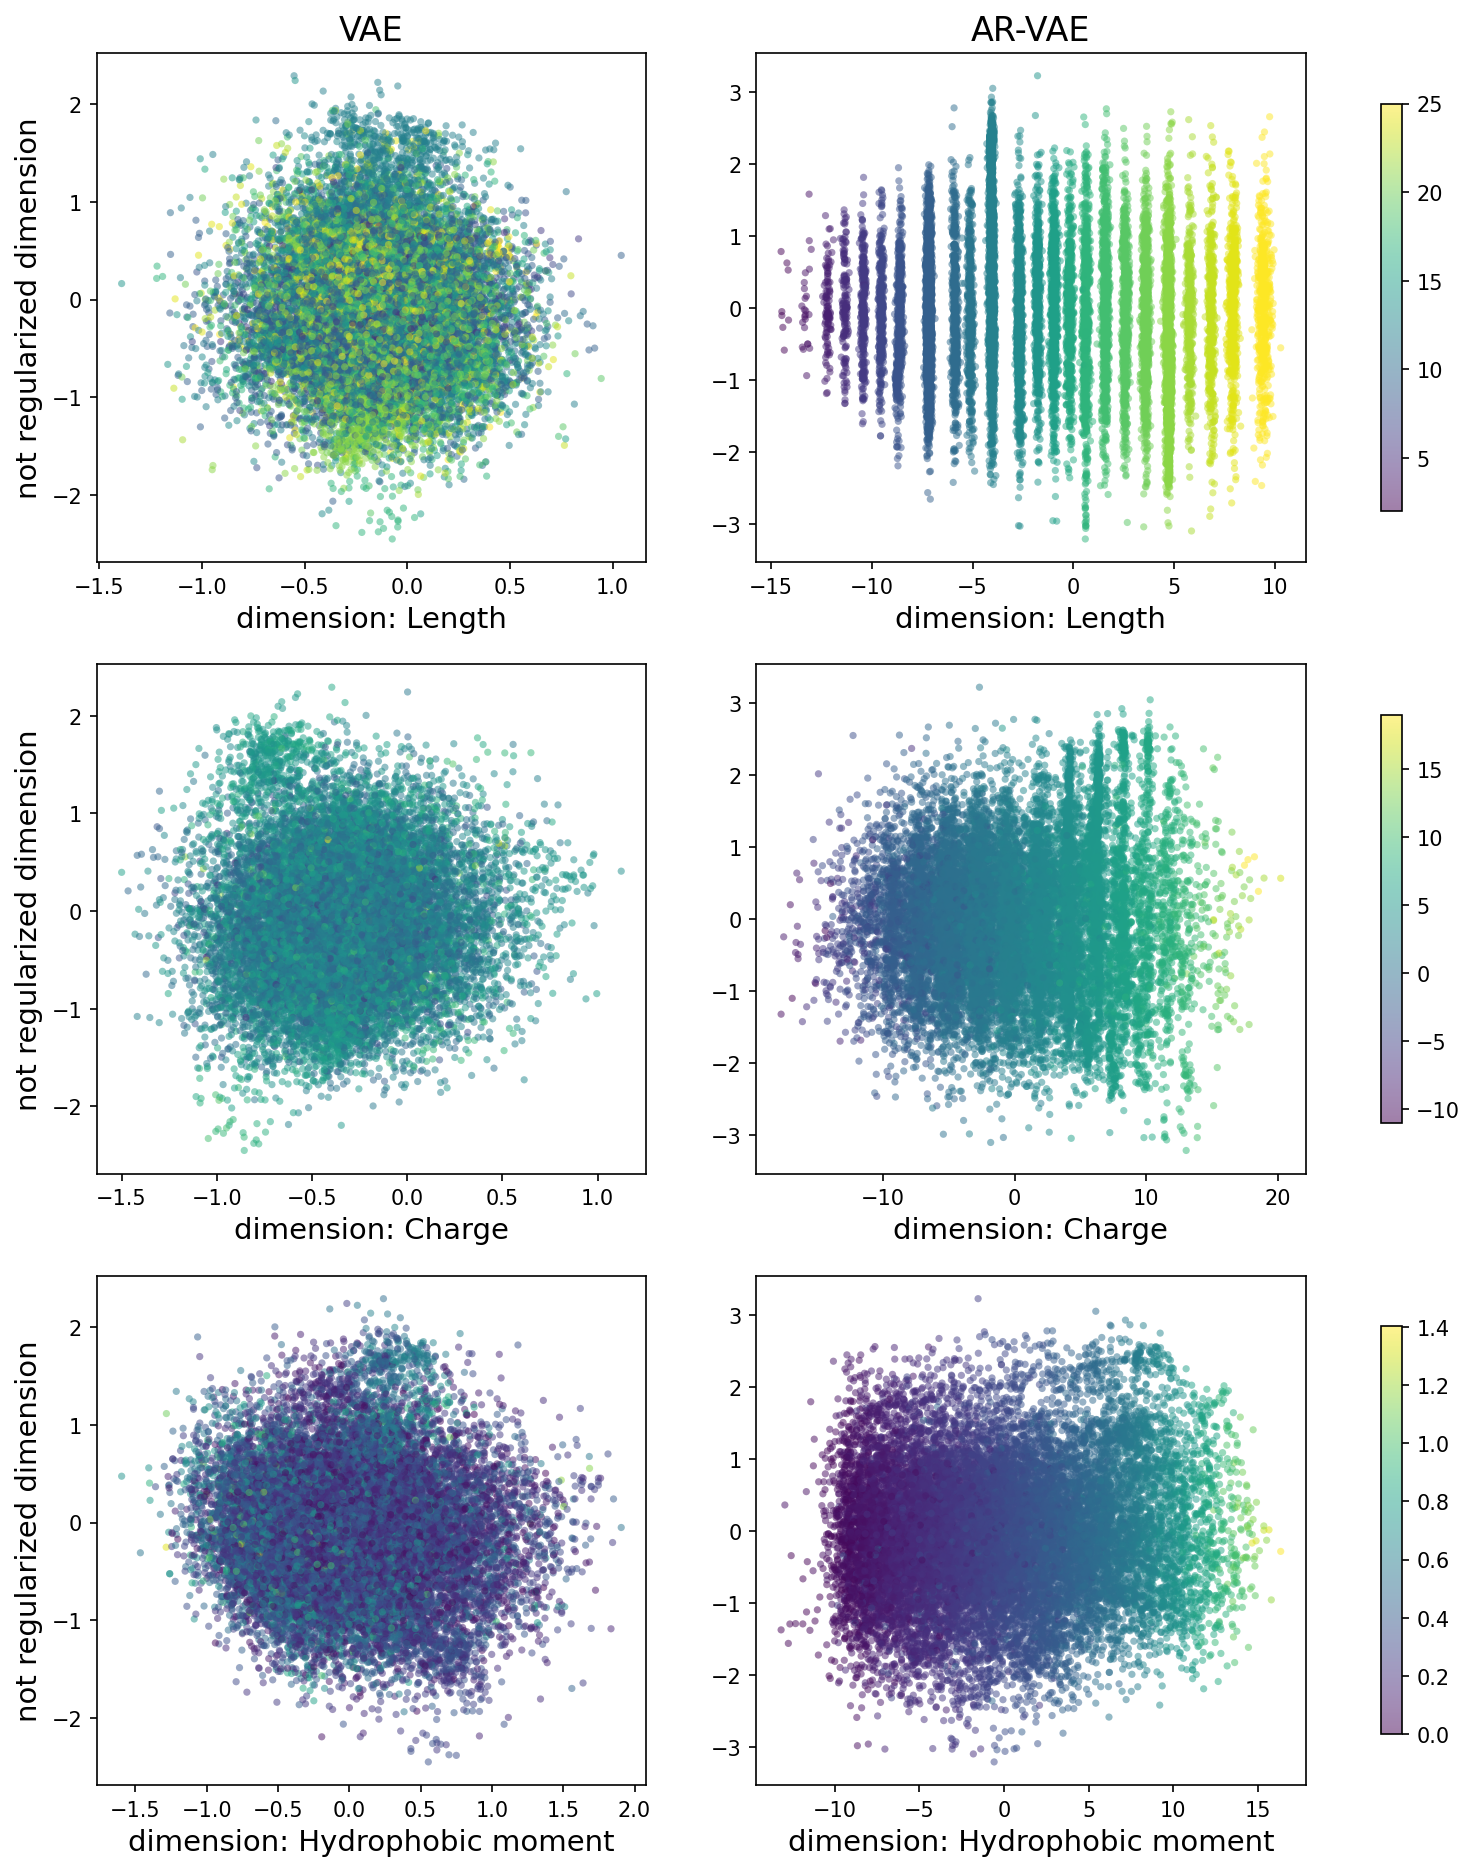

In [ ]:
    attr_dims = [attr_dict[attr] for attr in attr_dict.keys()]
    non_attr_dims = [a for a in range(params['latent_dim']) if a not in attr_dims]
    for non_attr_dim in non_attr_dims:
        if non_attr_dim == 40:
            plot_latent_surface(
                    q_distr,
                    decoder_iwae,
                    decoder_arvae,
                    dim1=attr_dims,
                    dim2=non_attr_dim,
                    grid_res=0.15,
                    z_dim = params["latent_dim"]
            )

## Barploty

In [11]:
def _modularity(mutual_information):
    """
    Computes the modularity from mutual information.
    Args:
        mutual_information: np.array num_codes x num_attributes
    """
    squared_mi = np.square(mutual_information)
    max_squared_mi = np.max(squared_mi, axis=1)
    numerator = np.sum(squared_mi, axis=1) - max_squared_mi
    denominator = max_squared_mi * (squared_mi.shape[1] - 1.)
    delta = numerator / denominator
    modularity_score = 1. - delta
    index = (max_squared_mi == 0.)
    modularity_score[index] = 0.
    return modularity_score


def _compute_avg_diff_top_two(matrix):
    sorted_matrix = np.sort(matrix, axis=0)
    return sorted_matrix[-1, :] - sorted_matrix[-2, :]
    

In [43]:
ar_vae_metrics = {}

for model in ['VAE', 'AR-VAE']:
    if model == 'AR-VAE':
        encoder = encoder_arvae.eval()
        decoder = decoder_arvae.eval()
    elif model == 'VAE':
        encoder = encoder_iwae.eval()
        decoder = decoder_iwae.eval()        

    len_data = len(eval_loader.dataset)
    latent_codes = []
    attributes = []
    metrics = {}
    reg_dim = [0,1,2]
    
    K = 16
    C = 21
    for batch, labels, physchem, attributes_input in eval_loader: 
        peptides = batch.permute(1, 0).type(LongTensor).to(DEVICE) # S x B
        physchem_torch = physchem.to(DEVICE)
        S, B = peptides.shape
        mu, std = encoder(peptides)
        q_distr = Normal(mu, std)
        for _ in range(K):
            z = q_distr.rsample().to(DEVICE) # B, L
            latent_codes.append(z.reshape(-1, z.shape[1]).cpu().detach().numpy())
            labels_torch = labels.to(attributes_input.dtype).unsqueeze(1)
            attributes.append(cat(
                (attributes_input, labels_torch), dim=1
            ))
    
    latent_codes = np.concatenate(latent_codes, 0)
    attributes = cat(attributes, dim=0).numpy()
    attributes, attr_list = m.extract_relevant_attributes(attributes, reg_dim)
    interp_metrics = m.compute_interpretability_metric(
        latent_codes, attributes, attr_list
    )
    metrics["Interpretability"] = interp_metrics
    
    metrics['SAP_score'] = {}
    metrics['mig'] = {}
    metrics['modularity_score'] = {}
    metrics['corr_score'] = {}
    
    # Calculate MI
    mi = m.continuous_mutual_info(latent_codes, attributes)
    
    # Calculate SAP score
    sap_matrix = m._compute_score_matrix(latent_codes, attributes)
    sap_scores = _compute_avg_diff_top_two(sap_matrix)
    
    # Calculate MIG
    entropy = m.continuous_entropy(attributes)
    sorted_m = np.sort(mi, axis=0)[::-1]
    mig = np.divide(sorted_m[0, :] - sorted_m[1, :], entropy[:])
    
    # Calculate corr_score
    corr_matrix = m._compute_correlation_matrix(latent_codes, attributes)
    cor_score = np.max(corr_matrix, axis=0)
    
    for i, attr_name in tqdm(enumerate(attr_list)):
        metrics['SAP_score'][attr_name] = sap_scores[i]
        metrics['mig'][attr_name] = mig[i]
        modularity = _modularity(mi[:, i].reshape(-1, 56))
        metrics['modularity_score'][attr_name] = modularity.item()
        metrics['corr_score'][attr_name] = np.max(corr_matrix, axis=0)[i]
        
    metrics['SAP_score']['mean'] = np.mean(sap_scores)    
    metrics['mig']['mean'] = np.mean(mig)
    metrics['modularity_score']['mean'] = np.mean(_modularity(mi))
    metrics['corr_score']['mean'] = np.mean(np.max(corr_matrix, axis=0))
    
    ar_vae_metrics[model] = metrics

3it [00:59, 19.88s/it]
100%|███████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 31.21it/s]
3it [00:00, 22153.01it/s]
3it [00:59, 19.76s/it]
100%|███████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 30.54it/s]
3it [00:00, 12684.39it/s]


In [44]:
for model in ['VAE', 'AR-VAE']:
    ar_vae_metrics[model]['Interpretability']['mean'] = ar_vae_metrics[model]['Interpretability']['mean'][1]
    for attr_name in attr_list:
        ar_vae_metrics[model]['Interpretability'][attr_name] = ar_vae_metrics[model]['Interpretability'][attr_name][1]

In [45]:
ar_vae_metrics

{'VAE': {'Interpretability': {'Length': 0.5894438331355376,
   'Charge': 0.013257220391152624,
   'Hydrophobicity moment': 0.0094711759572369,
   'mean': 0.2040574098279757},
  'SAP_score': {'Length': 0.11572563038857464,
   'Charge': 0.02993206017333626,
   'Hydrophobicity moment': 0.004693722919311728,
   'mean': 0.050117137827074214},
  'mig': {'Length': 0.05411653324719861,
   'Charge': 0.005723663114703553,
   'Hydrophobicity moment': 0.002194428676596286,
   'mean': 0.020678208346166148},
  'modularity_score': {'Length': 0.8059842655211445,
   'Charge': 0.4216861215929366,
   'Hydrophobicity moment': 0.4833367578407729,
   'mean': 0.8189026521034454},
  'corr_score': {'Length': 0.7644393225276234,
   'Charge': 0.36072027044616833,
   'Hydrophobicity moment': 0.22551065647448829,
   'mean': 0.45022341648275993}},
 'AR-VAE': {'Interpretability': {'Length': 0.9976103262393925,
   'Charge': 0.9849871195254986,
   'Hydrophobicity moment': 0.9624904214836,
   'mean': 0.981695955749497}

In [27]:
iwae_metrics = pd.DataFrame.from_dict(ar_vae_metrics['VAE']).T
iwae_metrics = iwae_metrics.reset_index(names='attribute')
arvae_metrics = pd.DataFrame.from_dict(ar_vae_metrics['AR-VAE']).T
arvae_metrics = arvae_metrics.reset_index(names='attribute')

In [46]:
iwae_metrics = pd.concat([iwae_metrics, pd.DataFrame.from_dict(ar_vae_metrics['VAE']).T.reset_index(names='attribute')], ignore_index=True)
arvae_metrics = pd.concat([arvae_metrics, pd.DataFrame.from_dict(ar_vae_metrics['AR-VAE']).T.reset_index(names='attribute')], ignore_index=True)
iwae_metrics

,attribute,Length,Charge,Hydrophobicity moment,mean
0,Interpretability,0.589538,0.013291,0.009395,0.204075
1,SAP_score,0.115630,0.030025,0.004813,0.050156
2,mig,0.053346,0.007830,0.002258,0.021144
3,modularity_score,0.808279,0.430179,0.475865,0.818158
4,corr_score,0.764494,0.360852,0.225350,0.450232
5,Interpretability,0.589649,0.013294,0.009412,0.204118
6,SAP_score,0.115471,0.029887,0.004910,0.050089
7,mig,0.054197,0.006223,0.003178,0.021199
8,modularity_score,0.808216,0.427219,0.479110,0.818820
9,corr_score,0.764610,0.360826,0.225481,0.450306


In [47]:
# Zapisz do CSV z indeksem i separatorem średnikowym
iwae_metrics.to_csv('iwae_metrics.csv', sep=';', index=True)
arvae_metrics.to_csv('arvae_metrics.csv', sep=';', index=True)
# Wczytaj z powrotem, określając separator i kolumnę indeksu
iwae_metrics = pd.read_csv('iwae_metrics.csv', sep=';', index_col=0) # index_col=0 oznacza pierwszą kolumnę
arvae_metrics = pd.read_csv('arvae_metrics.csv', sep=';', index_col=0) # index_col=0 oznacza pierwszą ko

In [48]:
arvae_metrics

,attribute,Length,Charge,Hydrophobicity moment,mean
0,Interpretability,0.997609,0.984991,0.962516,0.981705
1,SAP_score,0.617138,0.830227,0.833641,0.760335
2,mig,0.840558,0.383293,0.041452,0.421768
3,modularity_score,0.993578,0.969624,0.872127,0.814516
4,corr_score,0.994843,0.997744,0.995775,0.996120
5,Interpretability,0.997610,0.985007,0.962439,0.981685
6,SAP_score,0.617235,0.830386,0.833589,0.760403
7,mig,0.841732,0.383971,0.043016,0.422906
8,modularity_score,0.993573,0.969429,0.872191,0.814250
9,corr_score,0.994843,0.997748,0.995784,0.996125


In [49]:
iwae_metrics['model'] = 'VAE'
arvae_metrics['model'] = 'AR-VAE'

# Połącz wierszami oba DataFrames
combined_metrics = pd.concat([iwae_metrics, arvae_metrics], ignore_index=True).rename(columns={'Hydrophobicity moment': 'HM'})

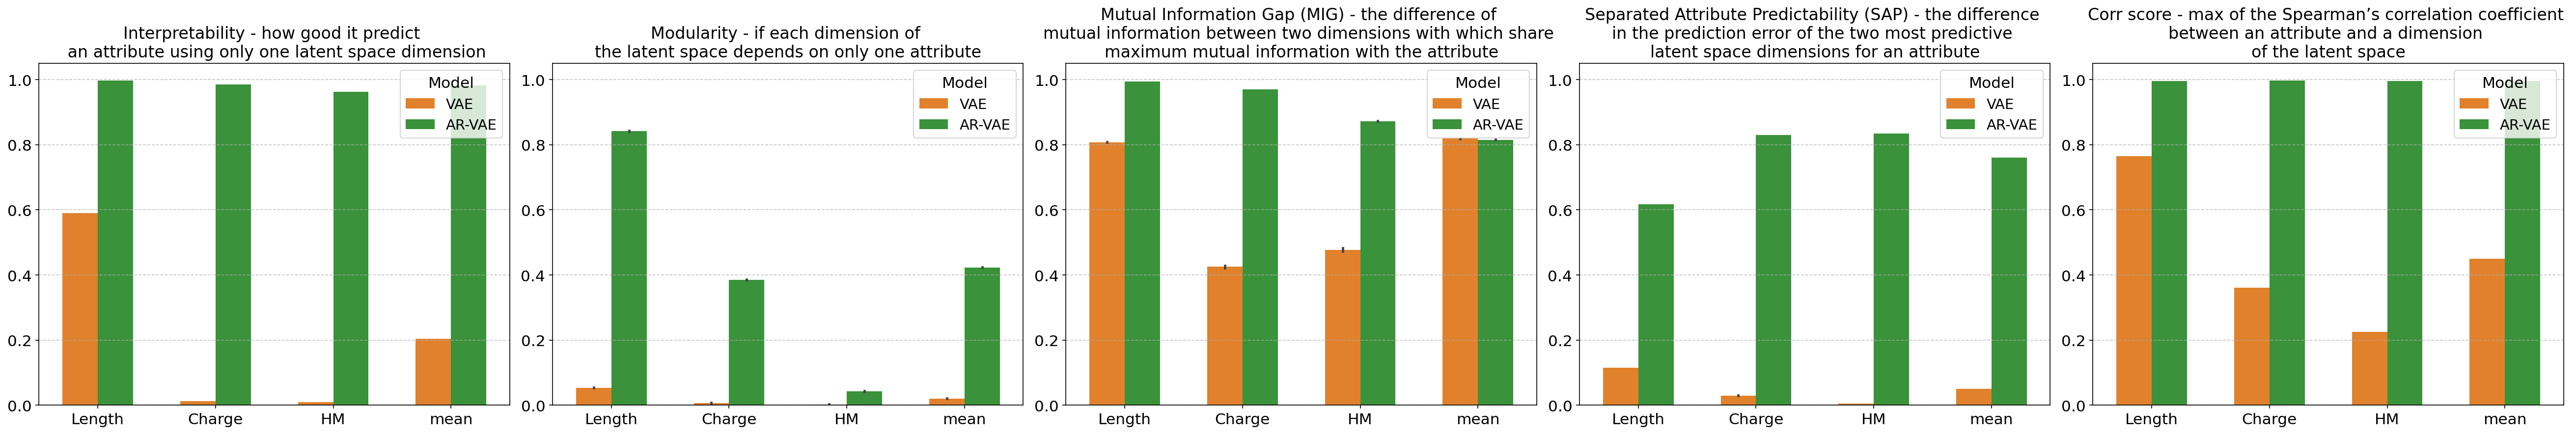

In [72]:
# ... (all your imports and data preparation)

fig, axes = plt.subplots(1, 5, figsize=(35,6), dpi=150)
custom_colors = ["#ff7f0e", "#2ca02c"]

# --- Plot 1: Interpretability ---
sns.barplot(x='feature', y='score_value', hue='model', data=plot_data_interpretability, ax=axes[0], palette=custom_colors, errorbar='sd', width=0.6)
axes[0].set_title(f'Interpretability - how good it predict \n an attribute using only one latent space dimension', fontsize = 16)
axes[0].set_ylabel('')
axes[0].set_xlabel('')  # <--- This is the key change
axes[0].set_ylim(0, 1.05)
axes[0].legend(title='Model', fontsize = 14, title_fontsize = 15, loc = 'upper right')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)

# --- Plot 2: MIG ---
sns.barplot(x='feature', y='score_value', hue='model', data=plot_data_mig, ax=axes[1], palette=custom_colors, errorbar='sd', width=0.6)
axes[1].set_title(f'Modularity - if each dimension of \nthe latent space depends on only one attribute', fontsize = 16)
axes[1].set_ylabel('')
axes[1].set_xlabel('')  # <--- This is the key change
axes[1].set_ylim(0, 1.05)
axes[1].legend(title='Model', fontsize = 14, title_fontsize = 15, loc = 'upper right')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

# --- Plot 3: Modularity Score ---
sns.barplot(x='feature', y='score_value', hue='model', data=plot_data_modularity_score, ax=axes[2], palette=custom_colors, errorbar='sd', width=0.6)
axes[2].set_title(f'Mutual Information Gap (MIG) - the difference of \nmutual information between two dimensions with which share \nmaximum mutual information with the attribute', fontsize = 16)
axes[2].set_ylabel('') # Changed label to be more specific
axes[2].set_xlabel('')  # <--- This is the key change
axes[2].set_ylim(0, 1.05)
axes[2].legend(title='Model', fontsize = 14, title_fontsize = 15, loc = 'upper right')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].tick_params(axis='x', labelsize=15)
axes[2].tick_params(axis='y', labelsize=15)

# --- Plot 4: SAP Score ---
sns.barplot(x='feature', y='score_value', hue='model', data=plot_data_SAP_score, ax=axes[3], palette=custom_colors, errorbar='sd', width=0.6)
axes[3].set_title(f'Separated Attribute Predictability (SAP) - the difference \nin the prediction error of the two most predictive \nlatent space dimensions for an attribute', fontsize = 16)
axes[3].set_ylabel('') # Changed label to be more specific
axes[3].set_xlabel('')  # <--- This is the key change
axes[3].set_ylim(0, 1.05)
axes[3].legend(title='Model', fontsize = 14, title_fontsize = 15, loc = 'upper right')
axes[3].grid(axis='y', linestyle='--', alpha=0.7)
axes[3].tick_params(axis='x', labelsize=15)
axes[3].tick_params(axis='y', labelsize=15)

# --- Plot 5: Corr Score ---
sns.barplot(x='feature', y='score_value', hue='model', data=plot_data_corr_score, ax=axes[4], palette=custom_colors, errorbar='sd', width=0.6)
axes[4].set_title(f'Corr score - max of the Spearman’s correlation coefficient \nbetween an attribute and a dimension \nof the latent space', fontsize = 16)
axes[4].set_ylabel('') # Changed label to be more specific
axes[4].set_xlabel('')  # <--- This is the key change
axes[4].set_ylim(0, 1.05)
axes[4].legend(title='Model', fontsize = 14, title_fontsize = 15, loc = 'upper right')
axes[4].grid(axis='y', linestyle='--', alpha=0.7)
axes[4].tick_params(axis='x', labelsize=15)
axes[4].tick_params(axis='y', labelsize=15)

plt.tight_layout()
fig.savefig("./barplots.png")
plt.show()